# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import imageio
%matplotlib inline

imageio.plugins.ffmpeg.download()

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#Find the 'y' intercept, i.e. 'b'
def find_y_intercept(x, y, m): 
    return y - m * x 
    
    
#find 'x' intercept at specified image height
def find_x_intercept(b, m, y):
    return (y - b) / m
 


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #counters for calculating slope average
    left_slope_counter = 0
    right_slope_counter = 0
    
    #variables for storing cumulative slope value
    left_slope_total = 0
    right_slope_total = 0
    
    #lowest points for extrapolating lines
    #set it to maximum possible values at the start
    max_left_x1 = 0
    max_left_y1 = 0
    min_right_x1 = img.shape[1]
    min_right_y1 = img.shape[0]
    
    #keep some global variables in case there are some abnormal lines
    #Currently we have no idea of these values
    global global_max_left_x1
    global global_max_left_y1
    global global_x_intercept_left
    
    global global_x_intercept_right
    global global_min_right_x1
    global global_min_right_y1
     
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # print(x1)
            # print(y1)
            # print(x2)
            # print(y2)

            slope =(y2-y1)/(x2-x1)
            
            if(slope > 0): #right side marking
                
                #print(x1)
                #print(y1)
                #print(x2)
                #print(y2)
                #add slope to the cumulative counter
                right_slope_total = right_slope_total + slope
                
                #store the points, no need to do it everytime
                if(right_slope_counter == 0):
                    right_x1 = x1
                    right_y1 = y1
                    right_x2 = x2
                    right_y2 = y2
                
                #and update the number of points for right
                right_slope_counter = right_slope_counter + 1
                
                #Hackeneyd method for gettng the highest point, surely there is a better way
                if (x1 < min_right_x1):
                    #print('debug comes here')
                    min_right_x1 = x1
                    min_right_y1 = y1
                
                if (x2 < min_right_x1):
                    min_right_x1 = x2
                    min_right_y1 = y2
                    
               
            #left side marking
            else:
                #add slope to the cumulative counter
                left_slope_total = left_slope_total + slope
                
                #store the points, no need to do it everytime
                if(left_slope_counter == 0):
                    left_x1 = x1
                    left_y1 = y1
                    left_x2 = x2
                    left_y2 = y2
                
                #and update the number of points for right
                left_slope_counter = left_slope_counter + 1
                
                #Hackeneyd method for gettng the highest point, surely there is a better way
                if (x1 > max_left_x1):
                    max_left_x1 = x1
                    max_left_y1 = y1
                
                if (x2 > max_left_x1):
                    max_left_x1 = x2
                    max_left_y1 = y2
                    
               
            # Remove horizontal lines in output by discarding minimal slopes
            #if(abs(slope) > 0.4):
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    #figure out the average slopes
    left_slope_average = left_slope_total / left_slope_counter
    right_slope_average = right_slope_total / right_slope_counter
            

    #Left lane x and y intercepts
    try:
        b_left = int(find_y_intercept(left_x1,left_y1,left_slope_average))
    except:
        b_left = 0
    # print(b_left)
    x_intercept_left = int(find_x_intercept(b_left,left_slope_average,img.shape[0])) #img.shape[0] is total height of image
    # print(x_intercept_right)
    
    #Right lane x and y intercepts
    b_right = int(find_y_intercept(right_x1,right_y1,right_slope_average))
    #print(b_right)
    x_intercept_right = int(find_x_intercept(b_right,right_slope_average,img.shape[0]))#img.shape[0] is total height of image
    #print(x_intercept_right)
    
    #print(max_left_x1)
    #print(max_left_y1)
    #print(min_right_x1)
    #print(min_right_y1)
    #print(b_right)
    #print(image.shape[1])
    
       
    #Check that our lines are not crossing each other
    if(max_left_x1 < min_right_x1): 
        cv2.line(img, (max_left_x1,max_left_y1), (x_intercept_left,img.shape[0]), color, 10)
        
        print (max_left_y1)
        
        #pop the current values into our global variable
        global_max_left_x1 = max_left_x1
        global_max_left_y1 = max_left_y1
        global_x_intercept_left = x_intercept_left
        
    else: #We have an issue Houston, line is not correct, use global variables to patch up this frame
        cv2.line(img, (global_max_left_x1,global_max_left_y1), (global_x_intercept_left,img.shape[0]), color, 10)
        
    #Check that our lines are not crossing each other
    if(min_right_x1 > max_left_x1):   
        cv2.line(img, (x_intercept_right,img.shape[0]), (min_right_x1,min_right_y1),color, 10)
        
        #pop the current values into our global variable
        global_x_intercept_right = x_intercept_right
        global_min_right_x1 = min_right_x1
        global_min_right_y1 = min_right_y1
    
    else: #We have an issue Houston, line is not correct, use global variables to patch up this frame
        cv2.line(img, (global_x_intercept_right,img.shape[0]), (global_min_right_x1,global_min_right_y1),color, 10)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


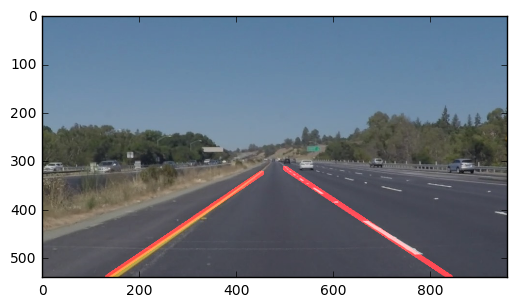

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
gray = grayscale(image) #convert to grayscale using our helper function

#Run our grayscale image through Gaussian Blur
kernel_size = 5 # Must be an odd number (3, 5, 7...)
blur_gray = gaussian_blur(gray,kernel_size)

#Detect edges using our Canny edge helper function
#pass our Gaussian blurred image to the canny edge detection function
edges=canny(blur_gray,50,150)

#Display Canny edge images
#plt.imshow(edges, cmap='gray')

#Define Areas of Interest
# Todo - use some sort of algorithm to define a polygon
# based on image size rather than hardcode parameters
bot_left = [80, 540]
bot_right = [980, 540]
apex_right = [500, 315]
apex_left = [410, 325]
vertices = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]

masked_image = region_of_interest(edges, vertices)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 0.8
theta = np.pi/180
threshold = 25
min_line_length = 50
max_line_gap = 200
line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

weighted_image = weighted_img(line_image, image)


#show the hough image
plt.imshow(weighted_image)
#plt.imshow(image) #Debug to see original image, comment/uncomment as required
#plt.imshow(gray, cmap='gray')  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
#plt.imshow(line_image)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
images = os.listdir("test_images/")
os.listdir("test_images/") #debug to display number of files

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

filename is solidWhiteCurve.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
filename is solidWhiteRight.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
filename is solidYellowCurve.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
filename is solidYellowCurve2.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
filename is solidYellowLeft.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
filename is whiteCarLaneSwitch.jpg
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320


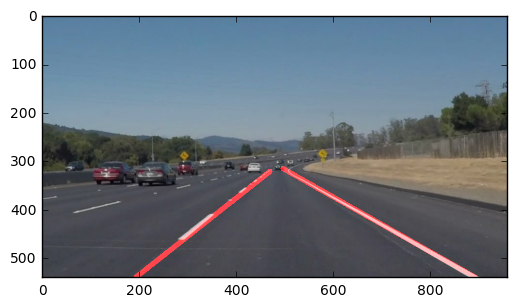

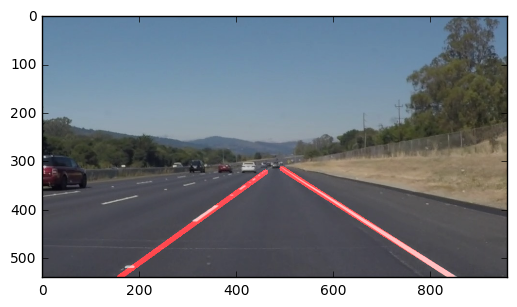

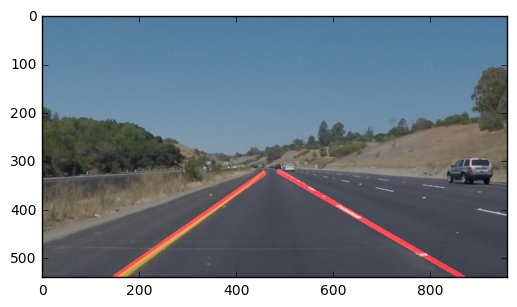

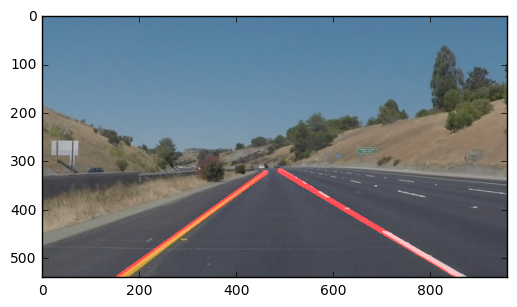

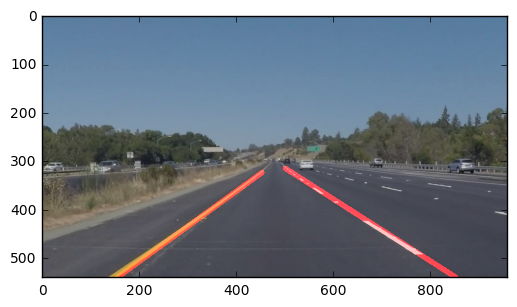

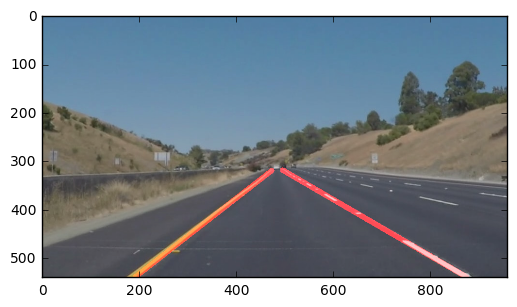

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def hough_image(filename):
    
    #reading in an image
    image = mpimg.imread('test_images/' + filename)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    gray = grayscale(image) #convert to grayscale using our helper function

    #Run our grayscale image through Gaussian Blur
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_blur(gray,kernel_size)

    #Detect edges using our Canny edge helper function
    #pass our Gaussian blurred image to the canny edge detection function
    edges=canny(blur_gray,50,150)

    #Display Canny edge images
    #plt.imshow(edges, cmap='gray')
    
    #Define Areas of Interest
    # Todo - use some sort of algorithm to define a polygon
    # based on image size rather than hardcode parameters
    bot_left = [80, 540]
    bot_right = [980, 540]
    apex_right = [500, 315]
    apex_left = [450, 325]
    vertices = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]

    masked_image = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 0.8
    theta = np.pi/180
    threshold = 25
    min_line_length = 50
    max_line_gap = 200
    line_image = np.copy(image)*0 #creating a blank to draw lines on

    # Run Hough on edge detected image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    weighted_image = weighted_img(line_image, image)


    #show the hough image
    plt.figure()
    plt.imshow(weighted_image)
    #cv2.imwrite('test_images/' + 'processed' + filename, weighted_image)
    mpimg.imsave('test_images/' + 'processed' + filename, weighted_image)
    #plt.imshow(image) #Debug to see original image, comment/uncomment as required
    #plt.imshow(gray, cmap='gray')  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


for file in images:
    output_filename = file #debug
    print('filename is ' + output_filename) #debug
    hough_image(file)







## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    gray = grayscale(image) #convert to grayscale using our helper function

    #Run our grayscale image through Gaussian Blur
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_blur(gray,kernel_size)

    #Detect edges using our Canny edge helper function
    #pass our Gaussian blurred image to the canny edge detection function
    edges=canny(blur_gray,50,150)

    #Display Canny edge images
    #plt.imshow(edges, cmap='gray')
    
    #Define Areas of Interest
    # Todo - use some sort of algorithm to define a polygon
    # based on image size rather than hardcode parameters
    bot_left = [80, 540]
    bot_right = [980, 540]
    apex_right = [500, 315]
    apex_left = [450, 325]
    vertices = [np.array([bot_left, bot_right, apex_right, apex_left], dtype=np.int32)]

    masked_image = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 0.8
    theta = np.pi/180
    threshold = 25
    min_line_length = 50
    max_line_gap = 200
    line_image = np.copy(image)*0 #creating a blank to draw lines on
    

    # Run Hough on edge detected image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)

    weighted_image = weighted_img(line_image, image)

    return weighted_image

Let's try the one with the solid white lane on the right first ...

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|                                                  | 0/222 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  0%|▏                                         | 1/222 [00:00<00:25,  8.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  1%|▌                                         | 3/222 [00:00<00:23,  9.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  2%|▉                                         | 5/222 [00:00<00:21, 10.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  3%|█▎                                        | 7/222 [00:00<00:19, 11.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  4%|█▋                                        | 9/222 [00:00<00:18, 11.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


  5%|██                                       | 11/222 [00:00<00:18, 11.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


  6%|██▍                                      | 13/222 [00:01<00:17, 11.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  7%|██▊                                      | 15/222 [00:01<00:16, 12.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  8%|███▏                                     | 17/222 [00:01<00:16, 12.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  9%|███▌                                     | 19/222 [00:01<00:15, 12.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


  9%|███▉                                     | 21/222 [00:01<00:15, 12.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 10%|████▏                                    | 23/222 [00:01<00:15, 12.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 11%|████▌                                    | 25/222 [00:02<00:15, 12.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 12%|████▉                                    | 27/222 [00:02<00:15, 12.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 13%|█████▎                                   | 29/222 [00:02<00:15, 12.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 14%|█████▋                                   | 31/222 [00:02<00:14, 13.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 15%|██████                                   | 33/222 [00:02<00:14, 13.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 16%|██████▍                                  | 35/222 [00:02<00:14, 13.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 17%|██████▊                                  | 37/222 [00:02<00:14, 12.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 18%|███████▏                                 | 39/222 [00:03<00:13, 13.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 18%|███████▌                                 | 41/222 [00:03<00:13, 13.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 19%|███████▉                                 | 43/222 [00:03<00:12, 14.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 20%|████████▎                                | 45/222 [00:03<00:12, 14.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


 21%|████████▋                                | 47/222 [00:03<00:15, 10.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


 22%|█████████                                | 49/222 [00:03<00:14, 11.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
337
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 23%|█████████▍                               | 51/222 [00:04<00:13, 12.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 24%|█████████▊                               | 53/222 [00:04<00:15, 10.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 25%|██████████▏                              | 55/222 [00:04<00:14, 11.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 26%|██████████▌                              | 57/222 [00:04<00:14, 11.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 27%|██████████▉                              | 59/222 [00:04<00:15, 10.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 27%|███████████▎                             | 61/222 [00:04<00:14, 10.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 28%|███████████▋                             | 63/222 [00:05<00:15, 10.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 29%|████████████                             | 65/222 [00:05<00:14, 10.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 30%|████████████▎                            | 67/222 [00:05<00:15,  9.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 31%|████████████▋                            | 69/222 [00:05<00:16,  9.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 32%|█████████████                            | 71/222 [00:06<00:14, 10.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 33%|█████████████▍                           | 73/222 [00:06<00:14, 10.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 34%|█████████████▊                           | 75/222 [00:06<00:15,  9.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 35%|██████████████▏                          | 77/222 [00:06<00:14,  9.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 36%|██████████████▌                          | 79/222 [00:06<00:13, 10.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


 36%|██████████████▉                          | 81/222 [00:06<00:11, 11.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 37%|███████████████▎                         | 83/222 [00:07<00:13, 10.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 38%|███████████████▋                         | 85/222 [00:07<00:13, 10.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 39%|████████████████                         | 87/222 [00:07<00:12, 11.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 40%|████████████████▍                        | 89/222 [00:07<00:12, 10.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 41%|████████████████▊                        | 91/222 [00:07<00:12, 10.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 42%|█████████████████▏                       | 93/222 [00:08<00:12, 10.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 43%|█████████████████▌                       | 95/222 [00:08<00:11, 11.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 44%|█████████████████▉                       | 97/222 [00:08<00:10, 11.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 45%|██████████████████▎                      | 99/222 [00:08<00:11, 10.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 45%|██████████████████▏                     | 101/222 [00:08<00:10, 11.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 46%|██████████████████▌                     | 103/222 [00:08<00:09, 11.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 47%|██████████████████▉                     | 105/222 [00:09<00:11, 10.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 48%|███████████████████▎                    | 107/222 [00:09<00:10, 10.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 49%|███████████████████▋                    | 109/222 [00:09<00:09, 11.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 50%|████████████████████                    | 111/222 [00:09<00:09, 11.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 51%|████████████████████▎                   | 113/222 [00:09<00:10, 10.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 52%|████████████████████▋                   | 115/222 [00:10<00:10, 10.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 53%|█████████████████████                   | 117/222 [00:10<00:09, 11.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 54%|█████████████████████▍                  | 119/222 [00:10<00:08, 11.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 55%|█████████████████████▊                  | 121/222 [00:10<00:09, 11.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 55%|██████████████████████▏                 | 123/222 [00:10<00:09, 10.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 56%|██████████████████████▌                 | 125/222 [00:10<00:08, 11.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 57%|██████████████████████▉                 | 127/222 [00:11<00:08, 11.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 58%|███████████████████████▏                | 129/222 [00:11<00:08, 11.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 59%|███████████████████████▌                | 131/222 [00:11<00:08, 11.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 60%|███████████████████████▉                | 133/222 [00:11<00:08, 10.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 61%|████████████████████████▎               | 135/222 [00:11<00:09,  9.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 62%|████████████████████████▋               | 137/222 [00:12<00:08, 10.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 63%|█████████████████████████               | 139/222 [00:12<00:07, 11.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 64%|█████████████████████████▍              | 141/222 [00:12<00:07, 10.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 64%|█████████████████████████▊              | 143/222 [00:12<00:07,  9.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 65%|██████████████████████████▏             | 145/222 [00:12<00:07, 10.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 66%|██████████████████████████▍             | 147/222 [00:13<00:06, 11.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 67%|██████████████████████████▊             | 149/222 [00:13<00:06, 10.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 68%|███████████████████████████▏            | 151/222 [00:13<00:06, 10.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 69%|███████████████████████████▌            | 153/222 [00:13<00:05, 11.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 70%|███████████████████████████▉            | 155/222 [00:13<00:06, 11.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 71%|████████████████████████████▎           | 157/222 [00:13<00:06, 10.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 72%|████████████████████████████▋           | 159/222 [00:14<00:06,  9.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 73%|█████████████████████████████           | 161/222 [00:14<00:06, 10.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 73%|█████████████████████████████▎          | 163/222 [00:14<00:05,  9.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 74%|█████████████████████████████▋          | 165/222 [00:14<00:05, 10.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 75%|██████████████████████████████          | 167/222 [00:14<00:05, 10.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 76%|██████████████████████████████▍         | 169/222 [00:15<00:04, 10.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 77%|██████████████████████████████▊         | 171/222 [00:15<00:04, 10.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 78%|███████████████████████████████▏        | 173/222 [00:15<00:04, 11.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 79%|███████████████████████████████▌        | 175/222 [00:15<00:04, 10.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 80%|███████████████████████████████▉        | 177/222 [00:15<00:04, 10.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 81%|████████████████████████████████▎       | 179/222 [00:16<00:03, 11.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 82%|████████████████████████████████▌       | 181/222 [00:16<00:03, 10.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 82%|████████████████████████████████▉       | 183/222 [00:16<00:03, 10.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 83%|█████████████████████████████████▎      | 185/222 [00:16<00:03, 11.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 84%|█████████████████████████████████▋      | 187/222 [00:16<00:03, 11.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 85%|██████████████████████████████████      | 189/222 [00:16<00:03, 10.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 86%|██████████████████████████████████▍     | 191/222 [00:17<00:02, 10.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 87%|██████████████████████████████████▊     | 193/222 [00:17<00:02, 11.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


 88%|███████████████████████████████████▏    | 195/222 [00:17<00:02, 10.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 89%|███████████████████████████████████▍    | 197/222 [00:17<00:02, 11.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 90%|███████████████████████████████████▊    | 199/222 [00:17<00:02, 10.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 91%|████████████████████████████████████▏   | 201/222 [00:18<00:01, 11.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 91%|████████████████████████████████████▌   | 203/222 [00:18<00:01, 11.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 92%|████████████████████████████████████▉   | 205/222 [00:18<00:01, 10.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 93%|█████████████████████████████████████▎  | 207/222 [00:18<00:01, 10.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 94%|█████████████████████████████████████▋  | 209/222 [00:18<00:01, 11.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 95%|██████████████████████████████████████  | 211/222 [00:18<00:00, 11.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 96%|██████████████████████████████████████▍ | 213/222 [00:19<00:00, 11.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 97%|██████████████████████████████████████▋ | 215/222 [00:19<00:00, 10.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 98%|███████████████████████████████████████ | 217/222 [00:19<00:00, 11.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 99%|███████████████████████████████████████▍| 219/222 [00:19<00:00, 12.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


100%|███████████████████████████████████████▊| 221/222 [00:19<00:00, 11.95it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 21.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|                                                  | 0/682 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  0%|                                          | 1/682 [00:00<01:16,  8.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


  0%|▏                                         | 3/682 [00:00<01:07, 10.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


  1%|▎                                         | 5/682 [00:00<01:06, 10.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  1%|▎                                         | 6/682 [00:00<01:07, 10.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  1%|▍                                         | 7/682 [00:00<01:08,  9.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  1%|▍                                         | 8/682 [00:00<01:09,  9.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


  1%|▌                                         | 9/682 [00:00<01:09,  9.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


  1%|▌                                        | 10/682 [00:00<01:09,  9.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  2%|▋                                        | 11/682 [00:01<01:09,  9.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  2%|▋                                        | 12/682 [00:01<01:10,  9.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  2%|▊                                        | 13/682 [00:01<01:12,  9.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


  2%|▊                                        | 14/682 [00:01<01:11,  9.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


  2%|▉                                        | 15/682 [00:01<01:11,  9.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  2%|▉                                        | 16/682 [00:01<01:11,  9.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  2%|█                                        | 17/682 [00:01<01:11,  9.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


  3%|█                                        | 18/682 [00:01<01:10,  9.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  3%|█▏                                       | 20/682 [00:02<01:09,  9.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  3%|█▎                                       | 21/682 [00:02<01:08,  9.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


  3%|█▎                                       | 22/682 [00:02<01:07,  9.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


  3%|█▍                                       | 23/682 [00:02<01:07,  9.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
335
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


  4%|█▌                                       | 25/682 [00:02<01:05,  9.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  4%|█▌                                       | 26/682 [00:02<01:06,  9.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
334


  4%|█▌                                       | 27/682 [00:02<01:08,  9.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


  4%|█▋                                       | 28/682 [00:02<01:07,  9.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330


  4%|█▊                                       | 30/682 [00:03<01:05,  9.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
337
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  5%|█▉                                       | 32/682 [00:03<01:03, 10.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  5%|██                                       | 34/682 [00:03<00:58, 11.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330


  5%|██▏                                      | 36/682 [00:03<00:53, 12.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
333


  6%|██▎                                      | 38/682 [00:03<00:47, 13.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
335


  6%|██▍                                      | 40/682 [00:03<00:45, 14.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
334
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
335


  6%|██▌                                      | 42/682 [00:03<00:44, 14.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
335
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
334


  6%|██▋                                      | 44/682 [00:03<00:42, 15.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
331


  7%|██▊                                      | 46/682 [00:04<00:41, 15.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


  7%|██▉                                      | 48/682 [00:04<00:51, 12.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
337


  7%|███                                      | 50/682 [00:04<00:47, 13.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330


  8%|███▏                                     | 52/682 [00:04<00:50, 12.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  8%|███▏                                     | 54/682 [00:04<01:06,  9.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


  8%|███▎                                     | 56/682 [00:05<01:10,  8.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


  9%|███▍                                     | 58/682 [00:05<01:01, 10.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  9%|███▌                                     | 60/682 [00:05<00:57, 10.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  9%|███▋                                     | 62/682 [00:05<01:02,  9.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


  9%|███▊                                     | 64/682 [00:05<00:55, 11.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
333


 10%|███▉                                     | 66/682 [00:06<00:50, 12.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


 10%|████                                     | 68/682 [00:06<01:04,  9.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 10%|████▏                                    | 70/682 [00:06<00:56, 10.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 11%|████▎                                    | 72/682 [00:06<00:51, 11.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 11%|████▍                                    | 74/682 [00:07<01:32,  6.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 11%|████▌                                    | 76/682 [00:07<01:16,  7.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 11%|████▋                                    | 78/682 [00:07<01:06,  9.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 12%|████▊                                    | 80/682 [00:07<01:08,  8.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 12%|████▉                                    | 82/682 [00:07<01:07,  8.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 12%|█████                                    | 84/682 [00:08<00:59, 10.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 13%|█████▏                                   | 86/682 [00:08<01:04,  9.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 13%|█████▎                                   | 88/682 [00:08<01:03,  9.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


 13%|█████▍                                   | 90/682 [00:08<00:56, 10.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 13%|█████▌                                   | 92/682 [00:09<01:12,  8.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 14%|█████▌                                   | 93/682 [00:09<01:08,  8.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 14%|█████▋                                   | 95/682 [00:09<00:59,  9.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 14%|█████▊                                   | 97/682 [00:09<00:55, 10.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 15%|█████▉                                   | 99/682 [00:09<00:58,  9.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 15%|█████▉                                  | 101/682 [00:09<00:57, 10.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 15%|██████                                  | 103/682 [00:10<00:51, 11.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 15%|██████▏                                 | 105/682 [00:10<01:00,  9.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 16%|██████▎                                 | 107/682 [00:10<00:58,  9.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 16%|██████▍                                 | 109/682 [00:10<00:52, 10.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 16%|██████▌                                 | 111/682 [00:10<00:51, 11.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 17%|██████▋                                 | 113/682 [00:10<00:54, 10.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 17%|██████▋                                 | 115/682 [00:11<00:55, 10.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 17%|██████▊                                 | 117/682 [00:11<00:49, 11.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 17%|██████▉                                 | 119/682 [00:11<01:11,  7.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 18%|███████                                 | 120/682 [00:11<01:15,  7.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 18%|███████                                 | 121/682 [00:12<01:45,  5.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 18%|███████▏                                | 123/682 [00:12<01:28,  6.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 18%|███████▎                                | 125/682 [00:12<01:28,  6.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 19%|███████▍                                | 127/682 [00:13<01:36,  5.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 19%|███████▌                                | 128/682 [00:13<01:24,  6.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 19%|███████▌                                | 130/682 [00:13<01:10,  7.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 19%|███████▋                                | 131/682 [00:13<01:11,  7.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 20%|███████▊                                | 133/682 [00:13<01:03,  8.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 20%|███████▉                                | 135/682 [00:13<01:05,  8.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 20%|███████▉                                | 136/682 [00:14<01:20,  6.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 20%|████████                                | 138/682 [00:14<01:07,  8.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 20%|████████▏                               | 139/682 [00:14<01:03,  8.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 21%|████████▏                               | 140/682 [00:14<01:14,  7.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 21%|████████▎                               | 141/682 [00:14<01:19,  6.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 21%|████████▎                               | 142/682 [00:14<01:17,  7.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 21%|████████▍                               | 144/682 [00:15<01:06,  8.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 21%|████████▌                               | 145/682 [00:15<01:06,  8.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 21%|████████▌                               | 146/682 [00:15<01:16,  7.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 22%|████████▌                               | 147/682 [00:15<01:12,  7.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 22%|████████▋                               | 149/682 [00:15<01:02,  8.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 22%|████████▊                               | 151/682 [00:15<01:12,  7.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 22%|████████▉                               | 152/682 [00:16<01:08,  7.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 23%|█████████                               | 154/682 [00:16<01:02,  8.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 23%|█████████                               | 155/682 [00:16<01:05,  8.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319


 23%|█████████▏                              | 157/682 [00:16<01:03,  8.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 23%|█████████▎                              | 159/682 [00:16<00:56,  9.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319


 24%|█████████▍                              | 161/682 [00:16<00:49, 10.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320


 24%|█████████▌                              | 163/682 [00:17<01:09,  7.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319


 24%|█████████▋                              | 165/682 [00:17<01:00,  8.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 24%|█████████▊                              | 167/682 [00:17<00:53,  9.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 25%|█████████▉                              | 169/682 [00:17<00:57,  8.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 25%|██████████                              | 171/682 [00:18<01:11,  7.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 25%|██████████▏                             | 173/682 [00:18<00:59,  8.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 26%|██████████▎                             | 175/682 [00:18<00:57,  8.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 26%|██████████▍                             | 177/682 [00:18<00:59,  8.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 26%|██████████▍                             | 178/682 [00:19<00:56,  8.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 26%|██████████▌                             | 180/682 [00:19<00:51,  9.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 27%|██████████▋                             | 182/682 [00:19<00:48, 10.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 27%|██████████▊                             | 184/682 [00:19<00:49, 10.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 27%|██████████▉                             | 186/682 [00:20<01:09,  7.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 28%|███████████                             | 188/682 [00:20<00:57,  8.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 28%|███████████▏                            | 190/682 [00:20<01:07,  7.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 28%|███████████▏                            | 191/682 [00:20<01:06,  7.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 28%|███████████▎                            | 193/682 [00:20<00:56,  8.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 29%|███████████▍                            | 195/682 [00:20<00:50,  9.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 29%|███████████▌                            | 197/682 [00:21<00:48,  9.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 29%|███████████▋                            | 199/682 [00:21<00:45, 10.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 29%|███████████▊                            | 201/682 [00:21<00:42, 11.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 30%|███████████▉                            | 203/682 [00:21<00:57,  8.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 30%|███████████▉                            | 204/682 [00:22<01:00,  7.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 30%|████████████                            | 205/682 [00:22<01:25,  5.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 30%|████████████▏                           | 207/682 [00:22<01:12,  6.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 30%|████████████▏                           | 208/682 [00:22<01:07,  7.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 31%|████████████▎                           | 209/682 [00:22<01:07,  7.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 31%|████████████▎                           | 210/682 [00:22<01:14,  6.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 31%|████████████▍                           | 211/682 [00:23<01:12,  6.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 31%|████████████▍                           | 212/682 [00:23<01:07,  6.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 31%|████████████▌                           | 214/682 [00:23<01:10,  6.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 32%|████████████▌                           | 215/682 [00:23<01:05,  7.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 32%|████████████▋                           | 216/682 [00:23<01:04,  7.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 32%|████████████▊                           | 218/682 [00:23<00:56,  8.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 32%|████████████▉                           | 220/682 [00:24<00:51,  8.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 33%|█████████████                           | 222/682 [00:24<00:48,  9.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 33%|█████████████▏                          | 224/682 [00:24<00:51,  8.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 33%|█████████████▎                          | 226/682 [00:24<00:47,  9.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 33%|█████████████▎                          | 227/682 [00:24<00:59,  7.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 34%|█████████████▍                          | 229/682 [00:25<00:50,  8.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 34%|█████████████▌                          | 231/682 [00:25<00:44, 10.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 34%|█████████████▋                          | 233/682 [00:25<00:45,  9.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 34%|█████████████▊                          | 235/682 [00:25<00:43, 10.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 35%|█████████████▉                          | 237/682 [00:25<00:41, 10.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 35%|██████████████                          | 239/682 [00:26<00:45,  9.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 35%|██████████████▏                         | 241/682 [00:26<00:40, 10.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 36%|██████████████▎                         | 243/682 [00:26<00:38, 11.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 36%|██████████████▎                         | 245/682 [00:27<01:13,  5.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 36%|██████████████▍                         | 247/682 [00:27<00:59,  7.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 37%|██████████████▌                         | 249/682 [00:27<00:50,  8.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 37%|██████████████▋                         | 251/682 [00:27<00:55,  7.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 37%|██████████████▊                         | 253/682 [00:27<00:47,  9.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 37%|██████████████▉                         | 255/682 [00:27<00:41, 10.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 38%|███████████████                         | 257/682 [00:28<00:45,  9.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 38%|███████████████▏                        | 259/682 [00:28<00:52,  8.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 38%|███████████████▎                        | 261/682 [00:28<00:46,  9.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 39%|███████████████▍                        | 263/682 [00:28<00:46,  9.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


 39%|███████████████▌                        | 265/682 [00:28<00:40, 10.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 39%|███████████████▋                        | 267/682 [00:29<00:43,  9.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 39%|███████████████▊                        | 269/682 [00:29<00:38, 10.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 40%|███████████████▉                        | 271/682 [00:29<00:52,  7.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 40%|████████████████                        | 273/682 [00:29<00:45,  8.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 40%|████████████████▏                       | 275/682 [00:30<00:40,  9.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 41%|████████████████▏                       | 277/682 [00:30<00:50,  7.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319


 41%|████████████████▎                       | 279/682 [00:30<00:44,  9.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 41%|████████████████▍                       | 281/682 [00:30<00:39, 10.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 41%|████████████████▌                       | 283/682 [00:30<00:44,  9.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 42%|████████████████▋                       | 285/682 [00:31<00:38, 10.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 42%|████████████████▊                       | 287/682 [00:31<00:40,  9.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 42%|████████████████▉                       | 289/682 [00:31<00:53,  7.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 43%|█████████████████                       | 291/682 [00:31<00:45,  8.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 43%|█████████████████▏                      | 293/682 [00:32<00:47,  8.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 43%|█████████████████▏                      | 294/682 [00:32<01:23,  4.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 43%|█████████████████▎                      | 296/682 [00:32<01:06,  5.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 44%|█████████████████▍                      | 297/682 [00:32<00:59,  6.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 44%|█████████████████▍                      | 298/682 [00:33<00:57,  6.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


 44%|█████████████████▌                      | 299/682 [00:33<01:03,  6.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


 44%|█████████████████▋                      | 301/682 [00:33<00:52,  7.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 44%|█████████████████▊                      | 303/682 [00:33<00:44,  8.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 45%|█████████████████▉                      | 305/682 [00:33<00:40,  9.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 45%|██████████████████                      | 307/682 [00:33<00:38,  9.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 45%|██████████████████                      | 309/682 [00:34<00:39,  9.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 46%|██████████████████▏                     | 311/682 [00:34<00:38,  9.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330


 46%|██████████████████▎                     | 313/682 [00:34<00:34, 10.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330


 46%|██████████████████▍                     | 315/682 [00:34<00:53,  6.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 46%|██████████████████▌                     | 317/682 [00:35<00:44,  8.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 47%|██████████████████▋                     | 319/682 [00:35<00:38,  9.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 47%|██████████████████▊                     | 321/682 [00:35<00:44,  8.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 47%|██████████████████▉                     | 323/682 [00:35<00:37,  9.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 48%|███████████████████                     | 325/682 [00:35<00:33, 10.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 48%|███████████████████▏                    | 327/682 [00:36<00:37,  9.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 48%|███████████████████▎                    | 329/682 [00:36<00:33, 10.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


 49%|███████████████████▍                    | 331/682 [00:36<00:30, 11.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 49%|███████████████████▌                    | 333/682 [00:36<00:34, 10.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 49%|███████████████████▋                    | 335/682 [00:36<00:32, 10.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 49%|███████████████████▊                    | 337/682 [00:36<00:29, 11.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 50%|███████████████████▉                    | 339/682 [00:37<00:31, 10.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 50%|████████████████████                    | 341/682 [00:37<00:33, 10.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 50%|████████████████████                    | 343/682 [00:37<00:31, 10.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 51%|████████████████████▏                   | 345/682 [00:37<00:28, 11.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 51%|████████████████████▎                   | 347/682 [00:37<00:31, 10.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
331


 51%|████████████████████▍                   | 349/682 [00:38<00:33, 10.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
331
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330


 51%|████████████████████▌                   | 351/682 [00:38<00:29, 11.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


 52%|████████████████████▋                   | 353/682 [00:38<00:32, 10.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328


 52%|████████████████████▊                   | 355/682 [00:38<00:30, 10.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
330


 52%|████████████████████▉                   | 357/682 [00:38<00:28, 11.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
331


 53%|█████████████████████                   | 359/682 [00:39<00:31, 10.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


 53%|█████████████████████▏                  | 361/682 [00:39<00:27, 11.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
331
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
332


 53%|█████████████████████▎                  | 363/682 [00:39<00:27, 11.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
331
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
336


 54%|█████████████████████▍                  | 365/682 [00:39<00:28, 11.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
333
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████████████████████▌                  | 367/682 [00:39<00:26, 11.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████████████████████▋                  | 369/682 [00:39<00:29, 10.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 54%|█████████████████████▊                  | 371/682 [00:40<00:26, 11.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


 55%|█████████████████████▉                  | 373/682 [00:40<00:24, 12.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 55%|█████████████████████▉                  | 375/682 [00:40<00:25, 11.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


 55%|██████████████████████                  | 377/682 [00:40<00:28, 10.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
328
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


 56%|██████████████████████▏                 | 379/682 [00:40<00:27, 11.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 56%|██████████████████████▎                 | 381/682 [00:40<00:26, 11.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 56%|██████████████████████▍                 | 383/682 [00:41<00:29, 10.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 56%|██████████████████████▌                 | 385/682 [00:41<00:26, 11.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 57%|██████████████████████▋                 | 387/682 [00:41<00:24, 11.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 57%|██████████████████████▊                 | 389/682 [00:41<00:28, 10.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 57%|██████████████████████▉                 | 391/682 [00:41<00:25, 11.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 58%|███████████████████████                 | 393/682 [00:41<00:25, 11.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 58%|███████████████████████▏                | 395/682 [00:42<00:26, 10.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 58%|███████████████████████▎                | 397/682 [00:42<00:25, 11.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329


 59%|███████████████████████▍                | 399/682 [00:42<00:23, 12.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 59%|███████████████████████▌                | 401/682 [00:42<00:26, 10.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 59%|███████████████████████▋                | 403/682 [00:42<00:24, 11.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 59%|███████████████████████▊                | 405/682 [00:43<00:25, 10.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 60%|███████████████████████▊                | 407/682 [00:43<00:24, 11.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 60%|███████████████████████▉                | 409/682 [00:43<00:22, 12.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 60%|████████████████████████                | 411/682 [00:43<00:27,  9.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 61%|████████████████████████▏               | 413/682 [00:43<00:25, 10.75it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 61%|████████████████████████▎               | 415/682 [00:43<00:22, 11.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
329
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 61%|████████████████████████▍               | 417/682 [00:44<00:25, 10.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 61%|████████████████████████▌               | 419/682 [00:44<00:22, 11.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 62%|████████████████████████▋               | 421/682 [00:44<00:23, 11.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 62%|████████████████████████▊               | 423/682 [00:44<00:22, 11.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 62%|████████████████████████▉               | 425/682 [00:44<00:24, 10.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 63%|█████████████████████████               | 427/682 [00:45<00:21, 11.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 63%|█████████████████████████▏              | 429/682 [00:45<00:20, 12.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 63%|█████████████████████████▎              | 431/682 [00:45<00:23, 10.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325


 63%|█████████████████████████▍              | 433/682 [00:45<00:22, 11.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 64%|█████████████████████████▌              | 435/682 [00:45<00:22, 10.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 64%|█████████████████████████▋              | 437/682 [00:45<00:20, 11.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 64%|█████████████████████████▋              | 439/682 [00:46<00:20, 11.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 65%|█████████████████████████▊              | 441/682 [00:46<00:24, 10.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 65%|█████████████████████████▉              | 443/682 [00:46<00:22, 10.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 65%|██████████████████████████              | 445/682 [00:46<00:21, 11.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 66%|██████████████████████████▏             | 447/682 [00:46<00:22, 10.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 66%|██████████████████████████▎             | 449/682 [00:47<00:20, 11.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 66%|██████████████████████████▍             | 451/682 [00:47<00:20, 11.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 66%|██████████████████████████▌             | 453/682 [00:47<00:19, 11.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 67%|██████████████████████████▋             | 455/682 [00:47<00:19, 11.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 67%|██████████████████████████▊             | 457/682 [00:47<00:21, 10.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 67%|██████████████████████████▉             | 459/682 [00:47<00:20, 11.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 68%|███████████████████████████             | 461/682 [00:48<00:18, 11.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 68%|███████████████████████████▏            | 463/682 [00:48<00:20, 10.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 68%|███████████████████████████▎            | 465/682 [00:48<00:20, 10.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 68%|███████████████████████████▍            | 467/682 [00:48<00:18, 11.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 69%|███████████████████████████▌            | 469/682 [00:48<00:18, 11.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 69%|███████████████████████████▌            | 471/682 [00:49<00:21,  9.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 69%|███████████████████████████▋            | 473/682 [00:49<00:18, 11.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 70%|███████████████████████████▊            | 475/682 [00:49<00:17, 12.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 70%|███████████████████████████▉            | 477/682 [00:49<00:18, 11.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 70%|████████████████████████████            | 479/682 [00:49<00:17, 11.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 71%|████████████████████████████▏           | 481/682 [00:49<00:18, 10.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 71%|████████████████████████████▎           | 483/682 [00:50<00:17, 11.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 71%|████████████████████████████▍           | 485/682 [00:50<00:17, 11.14it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 71%|████████████████████████████▌           | 487/682 [00:50<00:18, 10.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 72%|████████████████████████████▋           | 489/682 [00:50<00:17, 11.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 72%|████████████████████████████▊           | 491/682 [00:50<00:16, 11.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 72%|████████████████████████████▉           | 493/682 [00:51<00:17, 10.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 73%|█████████████████████████████           | 495/682 [00:51<00:17, 10.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 73%|█████████████████████████████▏          | 497/682 [00:51<00:15, 12.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 73%|█████████████████████████████▎          | 499/682 [00:51<00:17, 10.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 73%|█████████████████████████████▍          | 501/682 [00:51<00:18,  9.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 74%|█████████████████████████████▌          | 503/682 [00:51<00:16, 10.82it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 74%|█████████████████████████████▌          | 505/682 [00:52<00:17, 10.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 74%|█████████████████████████████▋          | 507/682 [00:52<00:15, 11.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 75%|█████████████████████████████▊          | 509/682 [00:52<00:17,  9.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 75%|█████████████████████████████▉          | 511/682 [00:52<00:18,  9.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 75%|██████████████████████████████          | 513/682 [00:52<00:15, 10.60it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 76%|██████████████████████████████▏         | 515/682 [00:53<00:15, 10.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 76%|██████████████████████████████▎         | 517/682 [00:53<00:16,  9.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 76%|██████████████████████████████▍         | 519/682 [00:53<00:14, 10.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 76%|██████████████████████████████▌         | 521/682 [00:53<00:15, 10.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 77%|██████████████████████████████▋         | 523/682 [00:53<00:14, 10.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 77%|██████████████████████████████▊         | 525/682 [00:54<00:13, 11.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 77%|██████████████████████████████▉         | 527/682 [00:54<00:15,  9.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 78%|███████████████████████████████         | 529/682 [00:54<00:13, 11.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320


 78%|███████████████████████████████▏        | 531/682 [00:54<00:14, 10.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320


 78%|███████████████████████████████▎        | 533/682 [00:54<00:15,  9.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 78%|███████████████████████████████▍        | 535/682 [00:55<00:13, 10.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320


 79%|███████████████████████████████▍        | 537/682 [00:55<00:14,  9.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320


 79%|███████████████████████████████▌        | 539/682 [00:55<00:13, 10.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 79%|███████████████████████████████▋        | 541/682 [00:55<00:12, 11.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 80%|███████████████████████████████▊        | 543/682 [00:55<00:14,  9.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 80%|███████████████████████████████▉        | 545/682 [00:55<00:12, 11.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 80%|████████████████████████████████        | 547/682 [00:56<00:11, 11.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 80%|████████████████████████████████▏       | 549/682 [00:56<00:13, 10.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 81%|████████████████████████████████▎       | 551/682 [00:56<00:11, 11.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 81%|████████████████████████████████▍       | 553/682 [00:56<00:10, 12.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 81%|████████████████████████████████▌       | 555/682 [00:56<00:11, 11.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 82%|████████████████████████████████▋       | 557/682 [00:57<00:12, 10.04it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 82%|████████████████████████████████▊       | 559/682 [00:57<00:11, 11.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 82%|████████████████████████████████▉       | 561/682 [00:57<00:10, 11.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 83%|█████████████████████████████████       | 563/682 [00:57<00:12,  9.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 83%|█████████████████████████████████▏      | 565/682 [00:57<00:11, 10.44it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 83%|█████████████████████████████████▎      | 567/682 [00:58<00:11,  9.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
325
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 83%|█████████████████████████████████▎      | 569/682 [00:58<00:11, 10.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 84%|█████████████████████████████████▍      | 571/682 [00:58<00:10, 10.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 84%|█████████████████████████████████▌      | 573/682 [00:58<00:10,  9.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 84%|█████████████████████████████████▋      | 575/682 [00:58<00:10,  9.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 85%|█████████████████████████████████▊      | 577/682 [00:58<00:09, 11.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 85%|█████████████████████████████████▉      | 579/682 [00:59<00:09, 10.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 85%|██████████████████████████████████      | 581/682 [00:59<00:09, 11.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 85%|██████████████████████████████████▏     | 583/682 [00:59<00:08, 11.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 86%|██████████████████████████████████▎     | 585/682 [00:59<00:10,  9.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320


 86%|██████████████████████████████████▍     | 587/682 [00:59<00:09, 10.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 86%|██████████████████████████████████▌     | 589/682 [01:00<00:08, 11.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 87%|██████████████████████████████████▋     | 591/682 [01:00<00:07, 11.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 87%|██████████████████████████████████▊     | 593/682 [01:00<00:08,  9.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319


 87%|██████████████████████████████████▉     | 595/682 [01:00<00:08, 10.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
319
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 88%|███████████████████████████████████     | 597/682 [01:00<00:07, 10.84it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 88%|███████████████████████████████████▏    | 599/682 [01:01<00:08,  9.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
320
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 88%|███████████████████████████████████▏    | 601/682 [01:01<00:07, 10.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 88%|███████████████████████████████████▎    | 603/682 [01:01<00:06, 11.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 89%|███████████████████████████████████▍    | 605/682 [01:01<00:06, 11.31it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 89%|███████████████████████████████████▌    | 607/682 [01:01<00:07, 10.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 89%|███████████████████████████████████▋    | 609/682 [01:01<00:06, 10.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 90%|███████████████████████████████████▊    | 611/682 [01:02<00:05, 11.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 90%|███████████████████████████████████▉    | 613/682 [01:02<00:06, 10.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 90%|████████████████████████████████████    | 615/682 [01:02<00:06, 10.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 90%|████████████████████████████████████▏   | 617/682 [01:02<00:05, 11.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 91%|████████████████████████████████████▎   | 619/682 [01:02<00:05, 11.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
321


 91%|████████████████████████████████████▍   | 621/682 [01:03<00:06, 10.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 91%|████████████████████████████████████▌   | 623/682 [01:03<00:05, 11.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 92%|████████████████████████████████████▋   | 625/682 [01:03<00:04, 11.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 92%|████████████████████████████████████▊   | 627/682 [01:03<00:05, 10.23it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 92%|████████████████████████████████████▉   | 629/682 [01:03<00:05, 10.07it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 93%|█████████████████████████████████████   | 631/682 [01:04<00:05,  9.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 93%|█████████████████████████████████████▏  | 633/682 [01:04<00:04, 10.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 93%|█████████████████████████████████████▏  | 635/682 [01:04<00:04, 11.51it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 93%|█████████████████████████████████████▎  | 637/682 [01:04<00:04, 10.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 94%|█████████████████████████████████████▍  | 639/682 [01:04<00:03, 10.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 94%|█████████████████████████████████████▌  | 641/682 [01:05<00:04,  9.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 94%|█████████████████████████████████████▋  | 643/682 [01:05<00:03, 10.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 95%|█████████████████████████████████████▊  | 645/682 [01:05<00:04,  9.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
322


 95%|█████████████████████████████████████▉  | 647/682 [01:05<00:03, 10.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 95%|██████████████████████████████████████  | 649/682 [01:05<00:02, 11.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 95%|██████████████████████████████████████▏ | 651/682 [01:05<00:03,  9.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 96%|██████████████████████████████████████▎ | 653/682 [01:06<00:02, 10.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 96%|██████████████████████████████████████▍ | 655/682 [01:06<00:02, 10.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 96%|██████████████████████████████████████▌ | 657/682 [01:06<00:02, 10.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 97%|██████████████████████████████████████▋ | 659/682 [01:06<00:02, 10.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 97%|██████████████████████████████████████▊ | 661/682 [01:06<00:02, 10.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 97%|██████████████████████████████████████▉ | 663/682 [01:07<00:01, 11.36it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 98%|███████████████████████████████████████ | 665/682 [01:07<00:01,  9.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 98%|███████████████████████████████████████ | 667/682 [01:07<00:01, 10.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


 98%|███████████████████████████████████████▏| 669/682 [01:07<00:01, 11.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323


 98%|███████████████████████████████████████▎| 671/682 [01:07<00:01,  9.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
323
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324


 99%|███████████████████████████████████████▍| 673/682 [01:08<00:00, 10.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


 99%|███████████████████████████████████████▌| 675/682 [01:08<00:00, 11.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327


 99%|███████████████████████████████████████▋| 677/682 [01:08<00:00, 11.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
327
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


100%|███████████████████████████████████████▊| 679/682 [01:08<00:00, 11.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
324
This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)
326


100%|███████████████████████████████████████▉| 681/682 [01:08<00:00, 11.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 11s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

* This was a pretty tough first project. Finding the Hough lines was easy enough, but extrapolating the lines took up most of my time and I had to resort to some pretty ugly techniques to do this. But the end result was worth it. The challenger video did not even compile for me due to Overflow issues with detecting intercepts, but trying to override that ended up with a very strange static line for me. I didn't have the time to debug this.

* Overall I think it was a great start and I must have taken 20 hours for this module rather than the 10. I also felt that the extrapolation kinda spoilt the fun because each everybody had to take up a different approach to arrive at a good lane marking lines.

* I was also unclear on identifying region of interest. I hardcoded values, but this should be straightforward by using ratios based on the image size rather than direct numbers. But then again I feel that that area of interest for a fixed mounted camera can be pretty easily defined as a polygon that adheres to certain standards rather than each engineer inventing his/her own model around this. So maybe Udacity should make this a standard helper function for future cohorts so that students can concentrate on the more meaty stuff rather than trying to figure out the exact regoin to cover. One of the major advantages of OOP and Python is reusability where engineers should be able to concentrate on using exising functions rather than build them from scratch and i'm sure there are a lot more important things to take care of in self-driving rather than trying to define a region of interest

* I also found it a little nerve wracking with region of interest definition. If the camera is mounted differently or maybe wide angled, then the whole setup goes for a toss. So maybe there is some advanced technique here that can be used that i'm unaware of

* I'm pretty sure my pipeline isn't robust enough for curves and other types of roads. Already, with minor curvature the lanes increase and decrease in length when ideally it should be a constant one (I feel). There should also be definitely some smoothing applied as the image feels jerky. I'm also feeling a little overwhelmed with the submission of some of the others who seem to be pros in the field. However, I'm confident that with my knowledge of OOPS concepts and reusing built-in functions and tricks, I should be able to come up with the necessary techniques for future projects

* One final note is that I found the Jupyter notebook to be a little odd in terms of python usage. Usually in Python you can write a function anywhere in the file, but here the cells are run in sequential order. So, that was a bit of a challenge for me to learn and understand

* Final note 2 - For some reason, probably a Jupyter notebook quirk, defining the values for Region of interest and Hough Parameters in an earlier cell does not seem to carry forward to a later cell. So, I've just kept it as is (it was a copy from the original cell). I have not had time to debug this further and make it all into 1 consolidated place as I would like to ideally keep it




## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|                                                  | 0/251 [00:00<?, ?it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  0%|▏                                         | 1/251 [00:00<00:38,  6.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  1%|▎                                         | 2/251 [00:00<00:37,  6.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  1%|▌                                         | 3/251 [00:00<00:38,  6.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  2%|▋                                         | 4/251 [00:00<00:39,  6.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  2%|▊                                         | 5/251 [00:00<00:41,  5.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  2%|█                                         | 6/251 [00:01<00:42,  5.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  3%|█▏                                        | 7/251 [00:01<00:41,  5.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  3%|█▎                                        | 8/251 [00:01<00:41,  5.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  4%|█▌                                        | 9/251 [00:01<00:39,  6.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  4%|█▋                                       | 10/251 [00:01<00:40,  5.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  4%|█▊                                       | 11/251 [00:01<00:44,  5.43it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  5%|█▉                                       | 12/251 [00:02<00:42,  5.68it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  5%|██                                       | 13/251 [00:02<00:44,  5.38it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  6%|██▎                                      | 14/251 [00:02<00:49,  4.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  6%|██▍                                      | 15/251 [00:02<00:53,  4.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  6%|██▌                                      | 16/251 [00:03<00:53,  4.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  7%|██▊                                      | 17/251 [00:03<00:51,  4.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  7%|██▉                                      | 18/251 [00:03<00:48,  4.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  8%|███                                      | 19/251 [00:03<00:45,  5.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  8%|███▎                                     | 20/251 [00:03<00:44,  5.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  8%|███▍                                     | 21/251 [00:03<00:40,  5.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  9%|███▌                                     | 22/251 [00:04<00:37,  6.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


  9%|███▊                                     | 23/251 [00:04<00:35,  6.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 10%|███▉                                     | 24/251 [00:04<00:35,  6.45it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 10%|████                                     | 25/251 [00:04<00:31,  7.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 11%|████▍                                    | 27/251 [00:04<00:28,  7.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 11%|████▌                                    | 28/251 [00:04<00:27,  8.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 12%|████▉                                    | 30/251 [00:04<00:26,  8.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 12%|█████                                    | 31/251 [00:05<00:27,  7.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 13%|█████▍                                   | 33/251 [00:05<00:26,  8.32it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 14%|█████▌                                   | 34/251 [00:05<00:26,  8.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 14%|█████▋                                   | 35/251 [00:05<00:26,  8.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 14%|█████▉                                   | 36/251 [00:05<00:31,  6.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 15%|██████                                   | 37/251 [00:05<00:32,  6.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 15%|██████▏                                  | 38/251 [00:06<00:29,  7.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 16%|██████▌                                  | 40/251 [00:06<00:26,  7.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 17%|██████▊                                  | 42/251 [00:06<00:24,  8.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 17%|███████                                  | 43/251 [00:06<00:23,  8.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 18%|███████▏                                 | 44/251 [00:06<00:25,  8.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 18%|███████▌                                 | 46/251 [00:06<00:24,  8.52it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 19%|███████▋                                 | 47/251 [00:07<00:24,  8.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 19%|███████▊                                 | 48/251 [00:07<00:23,  8.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 20%|████████                                 | 49/251 [00:07<00:25,  7.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 20%|████████▏                                | 50/251 [00:07<00:25,  7.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 20%|████████▎                                | 51/251 [00:07<00:25,  7.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 21%|████████▍                                | 52/251 [00:07<00:42,  4.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 21%|████████▋                                | 53/251 [00:08<00:36,  5.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 22%|████████▊                                | 54/251 [00:08<00:33,  5.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 22%|████████▉                                | 55/251 [00:08<00:33,  5.85it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 22%|█████████▏                               | 56/251 [00:08<00:36,  5.34it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 23%|█████████▎                               | 57/251 [00:08<00:33,  5.71it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 23%|█████████▍                               | 58/251 [00:08<00:39,  4.95it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 24%|█████████▋                               | 59/251 [00:09<00:36,  5.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 24%|█████████▊                               | 60/251 [00:09<00:33,  5.64it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 24%|█████████▉                               | 61/251 [00:10<01:04,  2.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 25%|██████████▏                              | 62/251 [00:10<00:55,  3.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 25%|██████████▎                              | 63/251 [00:10<00:53,  3.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 25%|██████████▍                              | 64/251 [00:10<00:44,  4.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 26%|██████████▌                              | 65/251 [00:10<00:43,  4.27it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 26%|██████████▊                              | 66/251 [00:11<00:39,  4.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 27%|██████████▉                              | 67/251 [00:11<00:36,  5.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 27%|███████████                              | 68/251 [00:11<00:33,  5.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 27%|███████████▎                             | 69/251 [00:11<00:32,  5.57it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 28%|███████████▍                             | 70/251 [00:11<00:30,  5.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 28%|███████████▌                             | 71/251 [00:11<00:30,  5.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 29%|███████████▊                             | 72/251 [00:11<00:31,  5.76it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 29%|███████████▉                             | 73/251 [00:12<00:30,  5.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 29%|████████████                             | 74/251 [00:12<00:28,  6.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 30%|████████████▎                            | 75/251 [00:12<00:29,  5.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 30%|████████████▍                            | 76/251 [00:12<00:30,  5.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 31%|████████████▌                            | 77/251 [00:12<00:28,  6.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 31%|████████████▋                            | 78/251 [00:12<00:26,  6.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 31%|████████████▉                            | 79/251 [00:13<00:29,  5.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 32%|█████████████                            | 80/251 [00:13<00:27,  6.20it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 32%|█████████████▏                           | 81/251 [00:13<00:32,  5.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 33%|█████████████▍                           | 82/251 [00:13<00:31,  5.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 33%|█████████████▌                           | 83/251 [00:13<00:30,  5.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 33%|█████████████▋                           | 84/251 [00:14<00:29,  5.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 34%|█████████████▉                           | 85/251 [00:14<00:28,  5.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 34%|██████████████                           | 86/251 [00:14<00:26,  6.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 35%|██████████████▏                          | 87/251 [00:14<00:31,  5.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 35%|██████████████▎                          | 88/251 [00:14<00:29,  5.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 35%|██████████████▌                          | 89/251 [00:14<00:26,  6.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 36%|██████████████▋                          | 90/251 [00:15<00:26,  6.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 36%|██████████████▊                          | 91/251 [00:15<00:28,  5.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 37%|███████████████                          | 92/251 [00:15<00:28,  5.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 37%|███████████████▏                         | 93/251 [00:15<00:27,  5.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 37%|███████████████▎                         | 94/251 [00:15<00:24,  6.39it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 38%|███████████████▌                         | 95/251 [00:15<00:25,  6.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 38%|███████████████▋                         | 96/251 [00:16<00:24,  6.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 39%|███████████████▊                         | 97/251 [00:16<00:29,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 39%|████████████████                         | 98/251 [00:16<00:27,  5.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 39%|████████████████▏                        | 99/251 [00:16<00:26,  5.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 40%|███████████████▉                        | 100/251 [00:16<00:24,  6.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 40%|████████████████                        | 101/251 [00:16<00:22,  6.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 41%|████████████████▎                       | 102/251 [00:17<00:27,  5.40it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 41%|████████████████▍                       | 103/251 [00:17<00:35,  4.13it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 41%|████████████████▌                       | 104/251 [00:17<00:32,  4.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 42%|████████████████▋                       | 105/251 [00:17<00:29,  4.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 42%|████████████████▉                       | 106/251 [00:18<00:27,  5.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 43%|█████████████████                       | 107/251 [00:18<00:26,  5.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 43%|█████████████████▏                      | 108/251 [00:18<00:25,  5.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 43%|█████████████████▎                      | 109/251 [00:18<00:26,  5.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 44%|█████████████████▌                      | 110/251 [00:18<00:29,  4.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 44%|█████████████████▋                      | 111/251 [00:19<00:32,  4.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 45%|█████████████████▊                      | 112/251 [00:19<00:30,  4.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 45%|██████████████████                      | 113/251 [00:19<00:32,  4.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 45%|██████████████████▏                     | 114/251 [00:19<00:28,  4.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 46%|██████████████████▎                     | 115/251 [00:19<00:30,  4.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 46%|██████████████████▍                     | 116/251 [00:20<00:34,  3.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 47%|██████████████████▋                     | 117/251 [00:20<00:32,  4.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 47%|██████████████████▊                     | 118/251 [00:20<00:28,  4.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 47%|██████████████████▉                     | 119/251 [00:20<00:27,  4.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 48%|███████████████████                     | 120/251 [00:21<00:25,  5.11it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 48%|███████████████████▎                    | 121/251 [00:21<00:30,  4.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 49%|███████████████████▍                    | 122/251 [00:21<00:26,  4.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 49%|███████████████████▌                    | 123/251 [00:21<00:24,  5.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 49%|███████████████████▊                    | 124/251 [00:21<00:21,  5.87it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 50%|███████████████████▉                    | 125/251 [00:21<00:23,  5.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 50%|████████████████████                    | 126/251 [00:22<00:22,  5.54it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 51%|████████████████████▏                   | 127/251 [00:22<00:20,  6.10it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 51%|████████████████████▍                   | 128/251 [00:22<00:27,  4.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 51%|████████████████████▌                   | 129/251 [00:22<00:25,  4.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 52%|████████████████████▋                   | 130/251 [00:22<00:22,  5.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 52%|████████████████████▉                   | 131/251 [00:23<00:20,  5.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 53%|█████████████████████                   | 132/251 [00:23<00:19,  6.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 53%|█████████████████████▏                  | 133/251 [00:23<00:18,  6.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 53%|█████████████████████▎                  | 134/251 [00:23<00:29,  3.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 54%|█████████████████████▌                  | 135/251 [00:24<00:25,  4.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 54%|█████████████████████▋                  | 136/251 [00:24<00:21,  5.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 55%|█████████████████████▊                  | 137/251 [00:24<00:19,  5.70it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 55%|█████████████████████▉                  | 138/251 [00:24<00:18,  6.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 55%|██████████████████████▏                 | 139/251 [00:24<00:17,  6.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 56%|██████████████████████▎                 | 140/251 [00:24<00:25,  4.29it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 56%|██████████████████████▍                 | 141/251 [00:25<00:22,  4.94it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 57%|██████████████████████▋                 | 142/251 [00:25<00:19,  5.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 57%|██████████████████████▊                 | 143/251 [00:25<00:18,  5.90it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 57%|██████████████████████▉                 | 144/251 [00:25<00:19,  5.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 58%|███████████████████████                 | 145/251 [00:25<00:18,  5.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 58%|███████████████████████▎                | 146/251 [00:26<00:22,  4.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 59%|███████████████████████▍                | 147/251 [00:26<00:20,  5.19it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 59%|███████████████████████▌                | 148/251 [00:26<00:18,  5.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 59%|███████████████████████▋                | 149/251 [00:26<00:17,  5.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 60%|███████████████████████▉                | 150/251 [00:26<00:16,  6.05it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 60%|████████████████████████                | 151/251 [00:26<00:15,  6.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 61%|████████████████████████▏               | 152/251 [00:27<00:18,  5.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 61%|████████████████████████▍               | 153/251 [00:27<00:18,  5.26it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 61%|████████████████████████▌               | 154/251 [00:27<00:17,  5.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 62%|████████████████████████▋               | 155/251 [00:27<00:17,  5.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 62%|████████████████████████▊               | 156/251 [00:27<00:16,  5.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 63%|█████████████████████████               | 157/251 [00:27<00:15,  6.15it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 63%|█████████████████████████▏              | 158/251 [00:28<00:17,  5.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 63%|█████████████████████████▎              | 159/251 [00:28<00:16,  5.48it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 64%|█████████████████████████▍              | 160/251 [00:28<00:15,  5.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 64%|█████████████████████████▋              | 161/251 [00:28<00:17,  5.16it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 65%|█████████████████████████▊              | 162/251 [00:28<00:16,  5.35it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 65%|█████████████████████████▉              | 163/251 [00:28<00:14,  6.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 65%|██████████████████████████▏             | 164/251 [00:29<00:14,  5.99it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 66%|██████████████████████████▎             | 165/251 [00:29<00:18,  4.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 66%|██████████████████████████▍             | 166/251 [00:29<00:16,  5.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 67%|██████████████████████████▌             | 167/251 [00:29<00:14,  5.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 67%|██████████████████████████▊             | 168/251 [00:29<00:13,  6.33it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 67%|██████████████████████████▉             | 169/251 [00:29<00:12,  6.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 68%|███████████████████████████             | 170/251 [00:30<00:12,  6.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 68%|███████████████████████████▎            | 171/251 [00:30<00:18,  4.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 69%|███████████████████████████▍            | 172/251 [00:30<00:16,  4.83it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 69%|███████████████████████████▌            | 173/251 [00:30<00:13,  5.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 69%|███████████████████████████▋            | 174/251 [00:30<00:13,  5.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 70%|███████████████████████████▉            | 175/251 [00:31<00:12,  6.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 70%|████████████████████████████            | 176/251 [00:31<00:12,  6.22it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 71%|████████████████████████████▏           | 177/251 [00:31<00:16,  4.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 71%|████████████████████████████▎           | 178/251 [00:31<00:13,  5.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 71%|████████████████████████████▌           | 179/251 [00:31<00:12,  5.65it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 72%|████████████████████████████▋           | 180/251 [00:32<00:12,  5.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 72%|████████████████████████████▊           | 181/251 [00:32<00:12,  5.74it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 73%|█████████████████████████████           | 182/251 [00:32<00:12,  5.46it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 73%|█████████████████████████████▏          | 183/251 [00:32<00:14,  4.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 73%|█████████████████████████████▎          | 184/251 [00:33<00:16,  4.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 74%|█████████████████████████████▍          | 185/251 [00:33<00:14,  4.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 74%|█████████████████████████████▋          | 186/251 [00:33<00:11,  5.49it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 75%|█████████████████████████████▊          | 187/251 [00:33<00:10,  5.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 75%|█████████████████████████████▉          | 188/251 [00:33<00:09,  6.59it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 75%|██████████████████████████████          | 189/251 [00:33<00:12,  5.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 76%|██████████████████████████████▎         | 190/251 [00:34<00:11,  5.12it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 76%|██████████████████████████████▍         | 191/251 [00:34<00:11,  5.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 76%|██████████████████████████████▌         | 192/251 [00:34<00:12,  4.58it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 77%|██████████████████████████████▊         | 193/251 [00:34<00:11,  4.92it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 77%|██████████████████████████████▉         | 194/251 [00:34<00:10,  5.50it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 78%|███████████████████████████████         | 195/251 [00:34<00:09,  6.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 78%|███████████████████████████████▏        | 196/251 [00:35<00:09,  5.67it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 78%|███████████████████████████████▍        | 197/251 [00:35<00:10,  5.28it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 79%|███████████████████████████████▌        | 198/251 [00:35<00:10,  4.86it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 79%|███████████████████████████████▋        | 199/251 [00:35<00:10,  5.09it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 80%|███████████████████████████████▊        | 200/251 [00:35<00:09,  5.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 80%|████████████████████████████████        | 201/251 [00:36<00:08,  5.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 80%|████████████████████████████████▏       | 202/251 [00:36<00:08,  5.61it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 81%|████████████████████████████████▎       | 203/251 [00:36<00:09,  5.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 81%|████████████████████████████████▌       | 204/251 [00:36<00:08,  5.42it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 82%|████████████████████████████████▋       | 205/251 [00:36<00:08,  5.62it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 82%|████████████████████████████████▊       | 206/251 [00:36<00:08,  5.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 82%|████████████████████████████████▉       | 207/251 [00:37<00:08,  5.41it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 83%|█████████████████████████████████▏      | 208/251 [00:37<00:07,  5.56it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 83%|█████████████████████████████████▎      | 209/251 [00:37<00:06,  6.03it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 84%|█████████████████████████████████▍      | 210/251 [00:37<00:06,  5.98it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 84%|█████████████████████████████████▋      | 211/251 [00:37<00:06,  5.81it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 84%|█████████████████████████████████▊      | 212/251 [00:38<00:06,  5.89it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 85%|█████████████████████████████████▉      | 213/251 [00:38<00:05,  6.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 85%|██████████████████████████████████      | 214/251 [00:38<00:07,  4.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 86%|██████████████████████████████████▎     | 215/251 [00:38<00:06,  5.30it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 86%|██████████████████████████████████▍     | 216/251 [00:38<00:06,  5.73it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 86%|██████████████████████████████████▌     | 217/251 [00:38<00:06,  5.55it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 87%|██████████████████████████████████▋     | 218/251 [00:39<00:05,  6.01it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 87%|██████████████████████████████████▉     | 219/251 [00:39<00:05,  6.00it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 88%|███████████████████████████████████     | 220/251 [00:39<00:06,  5.08it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 88%|███████████████████████████████████▏    | 221/251 [00:39<00:05,  5.77it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 88%|███████████████████████████████████▍    | 222/251 [00:39<00:04,  6.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 89%|███████████████████████████████████▌    | 223/251 [00:39<00:04,  6.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 89%|███████████████████████████████████▋    | 224/251 [00:40<00:03,  6.91it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 90%|███████████████████████████████████▊    | 225/251 [00:40<00:03,  6.93it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 90%|████████████████████████████████████    | 226/251 [00:40<00:04,  5.17it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 90%|████████████████████████████████████▏   | 227/251 [00:40<00:04,  5.80it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 91%|████████████████████████████████████▎   | 228/251 [00:40<00:03,  6.37it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 91%|████████████████████████████████████▍   | 229/251 [00:40<00:03,  6.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 92%|████████████████████████████████████▋   | 230/251 [00:41<00:03,  6.21it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 92%|████████████████████████████████████▊   | 231/251 [00:41<00:02,  6.88it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 92%|████████████████████████████████████▉   | 232/251 [00:41<00:03,  5.63it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 93%|█████████████████████████████████████▏  | 233/251 [00:41<00:03,  5.78it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 93%|█████████████████████████████████████▎  | 234/251 [00:41<00:02,  6.47it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 94%|█████████████████████████████████████▍  | 235/251 [00:41<00:02,  6.25it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 94%|█████████████████████████████████████▌  | 236/251 [00:41<00:02,  6.24it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 94%|█████████████████████████████████████▊  | 237/251 [00:42<00:02,  6.06it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 95%|█████████████████████████████████████▉  | 238/251 [00:42<00:02,  6.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 95%|██████████████████████████████████████  | 239/251 [00:42<00:02,  5.97it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 96%|██████████████████████████████████████▏ | 240/251 [00:42<00:01,  5.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 96%|██████████████████████████████████████▍ | 241/251 [00:42<00:01,  6.18it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 96%|██████████████████████████████████████▌ | 242/251 [00:43<00:01,  6.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 97%|██████████████████████████████████████▋ | 243/251 [00:43<00:01,  6.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 97%|██████████████████████████████████████▉ | 244/251 [00:43<00:01,  6.79it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 98%|███████████████████████████████████████ | 245/251 [00:43<00:01,  5.69it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 98%|███████████████████████████████████████▏| 246/251 [00:43<00:00,  5.72it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 98%|███████████████████████████████████████▎| 247/251 [00:43<00:00,  4.66it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 99%|███████████████████████████████████████▌| 248/251 [00:44<00:00,  4.96it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


 99%|███████████████████████████████████████▋| 249/251 [00:44<00:00,  5.53it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


100%|███████████████████████████████████████▊| 250/251 [00:44<00:00,  6.02it/s]

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


100%|████████████████████████████████████████| 251/251 [00:44<00:00,  6.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 48.2 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))